In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/goodreads-books-100k/GoodReads_100k_books.csv
/kaggle/input/environment-variable/.env


## Lấy dữ liệu từ AWS Athena

### Khởi tạo client lấy dữ liệu từ AWS Athena

In [2]:
import boto3
import os
from dotenv import load_dotenv
load_dotenv("/kaggle/input/environment-variable/.env") # lấy các biến môi trường

client = boto3.client(
    'athena',
    aws_access_key_id=os.getenv("DEV_AWS_ACCESS_KEY"),
    aws_secret_access_key=os.getenv("DEV_AWS_SECRET_KEY"),
    region_name=os.getenv("DEV_AWS_REGION_NAME")
 )

### Gọi và yêu cầu thực thi câu truy vấn

In [3]:
response = client.start_query_execution(
    QueryString='SELECT * FROM "dataset-books"."dataset_rt" ORDER BY id;',
    QueryExecutionContext={
        'Database': 'dataset-books'
    },
    ResultConfiguration={
        'OutputLocation': 's3://mxh-is353/query_result/'
        },
    WorkGroup='primary'
)
query_execution_id = response['QueryExecutionId']
print(f'QueryExecutionId: {query_execution_id}')

QueryExecutionId: 0e2e651f-a01e-48f6-91d3-d9765f616bf4


### Chờ đến khi truy vấn thành công

In [4]:
state = 'RUNNING'
while state != 'SUCCEEDED':
    response = client.get_query_execution(QueryExecutionId=query_execution_id)
    state = response['QueryExecution']['Status']['State']

### Lấy kết quả truy vấn, lưu các record trong results và columnns_info

In [5]:
results = []
columns_info = []
next_token = None

while True:
    if next_token is not None:
        response = client.get_query_results(QueryExecutionId=query_execution_id, NextToken=next_token)
    else:
        response = client.get_query_results(QueryExecutionId=query_execution_id)

    rows = response.get('ResultSet', {}).get('Rows', [])
    results.extend(rows)
    columns_info.extend(response.get('ResultSet', {}).get('ResultSetMetadata', {}).get('ColumnInfo', []))

    # Kiểm tra xem còn trang kế tiếp hay không
    next_token = response.get('NextToken')
    if not next_token:
        break
        
columns_info = columns_info[:20]

### Lưu kết quả truy vấn vào một file csv

In [6]:
import json
import csv
import os

# Chuyển đổi dữ liệu thành định dạng CSV
csv_data = []

# Thêm hàng chứa tên cột đầu tiên
header_row = [column['Name'] for column in columns_info]
csv_data.append(header_row)

# Thêm dữ liệu từ mỗi dòng (bắt đầu từ index 1 để bỏ qua dòng đầu tiên (header))
for row in results[1:]:
    cells = row['Data']
    # Chuyển đổi dữ liệu từng ô thành chuỗi và thêm vào hàng
    csv_row = [cell['VarCharValue'] for cell in cells]
    csv_data.append(csv_row)

# Lưu dữ liệu vào tệp CSV
csv_file_path = '/kaggle/working/data_from_athena.csv'
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(csv_data)

print(f'Kết quả đã được lưu vào tệp CSV: {csv_file_path}')

Kết quả đã được lưu vào tệp CSV: /kaggle/working/data_from_athena.csv


Lấy dataset đó ra

In [7]:
df_main = pd.read_csv('/kaggle/working/data_from_athena.csv')
df_main[:3]

_hoodie_commit_time      _hoodie_commit_seqno  _hoodie_record_key  \
0    20231111144618410  20231111144618410_0_3698                   1   
1    20231111144618410  20231111144618410_0_1484                  10   
2    20231111144618410   20231111144618410_0_954                 100   

   _hoodie_partition_path                                  _hoodie_file_name  \
0                     NaN  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
1                     NaN  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
2                     NaN  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   

                           author             bookformat  \
0            Laurence M. Hauptman              Hardcover   
1  B. Alan Wallace,Dalai Lama XIV              Hardcover   
2                      Andy Hoare  Mass Market Paperback   

                                                desc  \
0  Reveals that several hundred thousand Indians ...   
1  Discover your personal path to bliss,"This boo...   
2  Rogue trader patriarch Lucian Gerrit and his f...   

                                               genre  \
0  History,Military History,Civil War,American Hi...   
1  Religion,Buddhism,Philosophy,Spirituality,Psyc...   
2                        40k,Science Fiction,Fiction   

                                                 img        isbn  \
0  https://i.gr-assets.com/images/S/compressed.ph...  002914180X   
1  https://i.gr-assets.com/images/S/compressed.ph...  047146984X   
2  https://i.gr-assets.com/images/S/compressed.ph...         NaN   

         isbn13                                               link  pages  \
0  9.780000e+12  https://goodreads.com/book/show/1001053.Betwee...      0   
1  9.780000e+12  https://goodreads.com/book/show/100114.Genuine...    256   
2           NaN  https://goodreads.com/book/show/1001948.Star_o...    256   

   rating  reviews                                              title  \
0    3.52        5  Between Two Fires: American Indians in the Civ...   
1    4.10        7  Genuine Happiness: Meditation as the Path to F...   
2    3.28        3                                   Star of Damocles   

   totalratings   id                          ts  
0            33    1  2023-11-11T20:44:57.915602  
1           133   10  2023-11-11T20:45:04.296963  
2           102  100  2023-11-11T20:45:48.736516

# Process

#### Kiểm tra bộ dữ liệu

In [8]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3884 entries, 0 to 3883
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _hoodie_commit_time     3884 non-null   int64  
 1   _hoodie_commit_seqno    3884 non-null   object 
 2   _hoodie_record_key      3884 non-null   int64  
 3   _hoodie_partition_path  0 non-null      float64
 4   _hoodie_file_name       3884 non-null   object 
 5   author                  3884 non-null   object 
 6   bookformat              3783 non-null   object 
 7   desc                    3671 non-null   object 
 8   genre                   3521 non-null   object 
 9   img                     3784 non-null   object 
 10  isbn                    3540 non-null   object 
 11  isbn13                  3642 non-null   float64
 12  link                    3884 non-null   object 
 13  pages                   3884 non-null   int64  
 14  rating                  3884 non-null   

In [9]:
num_rows = df_main.shape[0]
print(f"Số dòng trong bộ dữ liệu là: {num_rows}")

Số dòng trong bộ dữ liệu là: 3884


In [10]:
def count_null_values(df):
    null_columns = df.columns[df.isnull().any()]
    results = []
    for column in null_columns:
        null_count = df[column].isnull().sum()
        column_type = df[column].dtypes
        results.append({
            'Cột': column,
            'Số lượng khuyết': f'{null_count}',
            'Kiểu': f'{column_type}'
        })
            
    return pd.DataFrame(results)

# Sử dụng hàm count_null_values trên DataFrame df_main
count_null_values(df_main)

Cột Số lượng khuyết     Kiểu
0  _hoodie_partition_path            3884  float64
1              bookformat             101   object
2                    desc             213   object
3                   genre             363   object
4                     img             100   object
5                    isbn             344   object
6                  isbn13             242  float64

In [11]:
# sửa tất cả các record trong cột _hoodie_partition_path thành aws và xóa hết các dòng có giá trị khuyết
df_main['_hoodie_partition_path'].fillna('aws', inplace=True)
df_main.dropna(inplace=True)

In [12]:
num_rows = df_main.shape[0]
print(f"Số dòng trong bộ dữ liệu sau khi xóa các giá trị khuyết là: {num_rows}")

Số dòng trong bộ dữ liệu sau khi xóa các giá trị khuyết là: 3041


#### Xuất ra file csv sau khi xử lý dữ liệu

In [13]:
# selected_columns = ['author', 'bookformat', 'desc', 'genre', 'img', 'isbn', 'isbn13', 'link', 'pages', 'rating', 'reviews', 'title', 'totalratings']
# df_selected = df_main[selected_columns]
# df_selected.to_csv('/kaggle/working/update_data.csv', index=False)
# print(f'Kết quả đã được lưu vào tệp CSV: {csv_file_path}')

In [14]:
pair_list =[]
for i, r in df_main.iterrows():
    author_list = str(r['author']).split(",")
    genre_list = str(r['genre']).split(",")
    for a in author_list:
        for g in genre_list:
            pair_list.append((a,g))
                
pair_df = pd.DataFrame(pair_list, columns=['author', 'genre']).drop_duplicates()
pair_df.head()

author               genre
0  Laurence M. Hauptman             History
1  Laurence M. Hauptman    Military History
2  Laurence M. Hauptman           Civil War
3  Laurence M. Hauptman    American History
4  Laurence M. Hauptman  American Civil War

In [15]:
authors = list(pair_df['author'])
genres = list(pair_df['genre'])

print(f"Số tác giả {len(np.unique(authors))}")
print(f"Số thể loại {len(np.unique(genres))}")
print(f"Số cạnh {len(pair_df)}")

Số tác giả 4239
Số thể loại 867
Số cạnh 34269


In [16]:
genre_counts = pair_df['genre'].value_counts()

# Get the top 10 genres
top_10_genres = genre_counts.head(10)

print(top_10_genres)

genre
Fiction          1656
Nonfiction       1520
Fantasy           787
History           661
Short Stories     648
Cultural          629
Anthologies       574
Literature        562
Reference         490
Historical        467
Name: count, dtype: int64


In [17]:
df_main['author'] = df_main['author'].str.split(',')

# Explode the lists in the 'author' column into separate rows
df_exploded = df_main.explode('author')

print(df_exploded)

      _hoodie_commit_time      _hoodie_commit_seqno  _hoodie_record_key  \
0       20231111144618410  20231111144618410_0_3698                   1   
1       20231111144618410  20231111144618410_0_1484                  10   
1       20231111144618410  20231111144618410_0_1484                  10   
4       20231111144618410  20231111144618410_0_2769                1001   
4       20231111144618410  20231111144618410_0_2769                1001   
...                   ...                       ...                 ...   
3878    20231111144618410  20231111144618410_0_1879                 994   
3879    20231111144618410  20231111144618410_0_2651                 995   
3880    20231111144618410   20231111144618410_0_348                 996   
3880    20231111144618410   20231111144618410_0_348                 996   
3881    20231111144618410  20231111144618410_0_1183                 997   

     _hoodie_partition_path  \
0                       aws   
1                       aws   
1     

In [18]:
author_counts = df_exploded['author'].value_counts()

# Get the top 10 author
top_10_author = author_counts.head(10)

print(top_10_author)

author
Harry Turtledove     46
Fritz Leiber         14
Joe R. Lansdale      13
Larry Niven          12
Jeanne Betancourt    10
Mi-Ri Hwang          10
Daisy Meadows         9
Patrick McDonnell     9
Peter Robinson        9
Mike Mignola          9
Name: count, dtype: int64


In [19]:
df_main['genre'] = df_main['genre'].str.split(',')

# Explode the lists in the 'author' column into separate rows
df_exploded = df_main.explode('genre')

In [20]:
print(df_exploded)

      _hoodie_commit_time      _hoodie_commit_seqno  _hoodie_record_key  \
0       20231111144618410  20231111144618410_0_3698                   1   
0       20231111144618410  20231111144618410_0_3698                   1   
0       20231111144618410  20231111144618410_0_3698                   1   
0       20231111144618410  20231111144618410_0_3698                   1   
0       20231111144618410  20231111144618410_0_3698                   1   
...                   ...                       ...                 ...   
3881    20231111144618410  20231111144618410_0_1183                 997   
3881    20231111144618410  20231111144618410_0_1183                 997   
3881    20231111144618410  20231111144618410_0_1183                 997   
3881    20231111144618410  20231111144618410_0_1183                 997   
3881    20231111144618410  20231111144618410_0_1183                 997   

     _hoodie_partition_path  \
0                       aws   
0                       aws   
0     

In [21]:
genre_counts = df_exploded['genre'].value_counts()

# Get the top 10 genres
top_10_genre = genre_counts.head(10)

print(top_10_genre)

genre
Nonfiction        1133
Fiction           1068
Fantasy            954
Romance            758
History            668
Childrens          666
Historical         657
Cultural           536
Sequential Art     490
Science            471
Name: count, dtype: int64


In [22]:
import pandas as pd

# Assuming your data is stored in a DataFrame named 'df' with a 'rating' column
top_10_highest_rated = df_main.nlargest(10, 'rating')

top_10_highest_rated

_hoodie_commit_time      _hoodie_commit_seqno  _hoodie_record_key  \
612     20231111144618410  20231111144618410_0_2660                 155   
2196    20231111144618410  20231111144618410_0_3589                2976   
3740    20231111144618410   20231111144618410_0_792                  87   
3787    20231111144618410  20231111144618410_0_2619                 911   
3866    20231111144618410  20231111144618410_0_2245                 983   
1343    20231111144618410  20231111144618410_0_2892                2207   
110     20231111144618410  20231111144618410_0_3635                1098   
2184    20231111144618410  20231111144618410_0_1268                2965   
3034    20231111144618410  20231111144618410_0_1149                 373   
250     20231111144618410  20231111144618410_0_1763                1223   

     _hoodie_partition_path  \
612                     aws   
2196                    aws   
3740                    aws   
3787                    aws   
3866                    aws   
1343                    aws   
110                     aws   
2184                    aws   
3034                    aws   
250                     aws   

                                      _hoodie_file_name  \
612   e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
2196  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
3740  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
3787  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
3866  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
1343  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
110   e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
2184  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
3034  e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   
250   e559ba7c-c8ff-4c96-8cd1-0354c5c3b4b2-0_0-29-85...   

                                                 author bookformat  \
612                                 [Pauline Matarasso]  Hardcover   
2196  [Will Shortz, Tetsuya Miyamoto, New York Times...  Paperback   
3740                                 [Horace A. Porter]  Hardcover   
3787                                      [Sue D'Auria]  Hardcover   
3866                                    [Paolo Mancosu]  Hardcover   
1343               [Malcolm Margolin, Michael   Harney]  Paperback   
110                                   [Neal D. Barnard]  Hardcover   
2184                                        [W.D. Hart]  Paperback   
3034                                       [Diane Wing]  Paperback   
250                                 [Shirley Hailstock]  Paperback   

                                                   desc  \
612   Queen's Mate tells the story of three remarkab...   
2196  KenKen has quickly become the successor to sud...   
3740  The first book to reassess Ralph Ellison after...   
3787  This volume of collected essays is dedicated t...   
3866  Paolo Mancosu presents a series of innovative ...   
1343  A guide for landowners, conservationists, and ...   
110   Whether your taste buds call for a touch of th...   
2184  The Evolution of Logic examines the relations ...   
3034  Get Better Results by Increasing Your Psychic ...   
250   Magnetic Hearts by Shirley Hailstock released ...   

                                                  genre  \
612                       [Cultural, France, Biography]   
2196                             [Mathematics, Puzzles]   
3740                                      [Music, Jazz]   
3787                          [Archaeology, Egyptology]   
3866          [Philosophy, Logic, Science, Mathematics]   
1343                    [Wildlife, Environment, Nature]   
110   [Food and Drink, Cookbooks, Food and Drink, Ve...   
2184                    [Philosophy, Philosophy, Logic]   
3034                                    [Occult, Tarot]   
250                 [Romance, African American Romance]   

                                                    img        isbn  \
612   https://i.gr-assets.com/images/S/compres

In [23]:
import pandas as pd

# Assuming your data is stored in a DataFrame named 'df' with a 'rating' column
top_10_highest_totalrated = df_main.nlargest(10, 'totalratings')


top_10_highest_totalrated['title']

2274                                            Jane Eyre
712                                      Clockwork Prince
1757              Dress Your Family in Corduroy and Denim
885     The Lean Startup: How Today's Entrepreneurs Us...
1701                              The Language of Flowers
944                                            The Reader
1142                                    Gabriel's Inferno
1991                                   Pushing the Limits
22                                      The Magician King
3653                                      A Long Way Down
Name: title, dtype: object

# Enrich

#### Làm sạch dữ liệu

In [24]:
df_main = pd.read_csv('/kaggle/working/data_from_athena.csv')
df_main['_hoodie_partition_path'].fillna('aws', inplace=True)

# df_main.dropna()
df_main.dropna(inplace=True)

df = df_main.head(1000)

In [25]:
my_genres = ["History", "Cultural", "Fiction", "Literature", "Fantasy", "Science","Romance", "Reference", "Historical"]
pair_list =[]

for i, r in df.iterrows():
    author_list = str(r['author']).split(",")
    genre_list = str(r['genre']).split(",")
    for a in author_list:
        for g in genre_list:
            if str(g) in my_genres:
                pair_list.append((a,g))
                
pair_df = pd.DataFrame(pair_list, columns=['author', 'genre']).drop_duplicates()
pair_df.head()

author      genre
0    Laurence M. Hauptman    History
1         Ladislas Farago   Cultural
2  Albert Spear Hitchcock  Reference
3          Edwin LefÃ¨vre    History
4        Roger Lowenstein    History

In [26]:
authors = list(pair_df['author'])
genres = list(pair_df['genre'])

print(f"Số tác giả {len(np.unique(authors))}")
print(f"Số thể loại {len(np.unique(genres))}")
print(f"Số cạnh {len(pair_df)}")

Số tác giả 1011
Số thể loại 9
Số cạnh 1859


In [27]:
import networkx as nx
import matplotlib.pyplot as plt

B= nx.Graph()
for i, r in pair_df.iterrows():
    B.add_edge(r['author'], r['genre'], weight = 1)
    
B.add_nodes_from(authors, bipartite = 1)
B.add_nodes_from(genres, bipartite = 0)

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 143 (\x8f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 144 (\x90) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


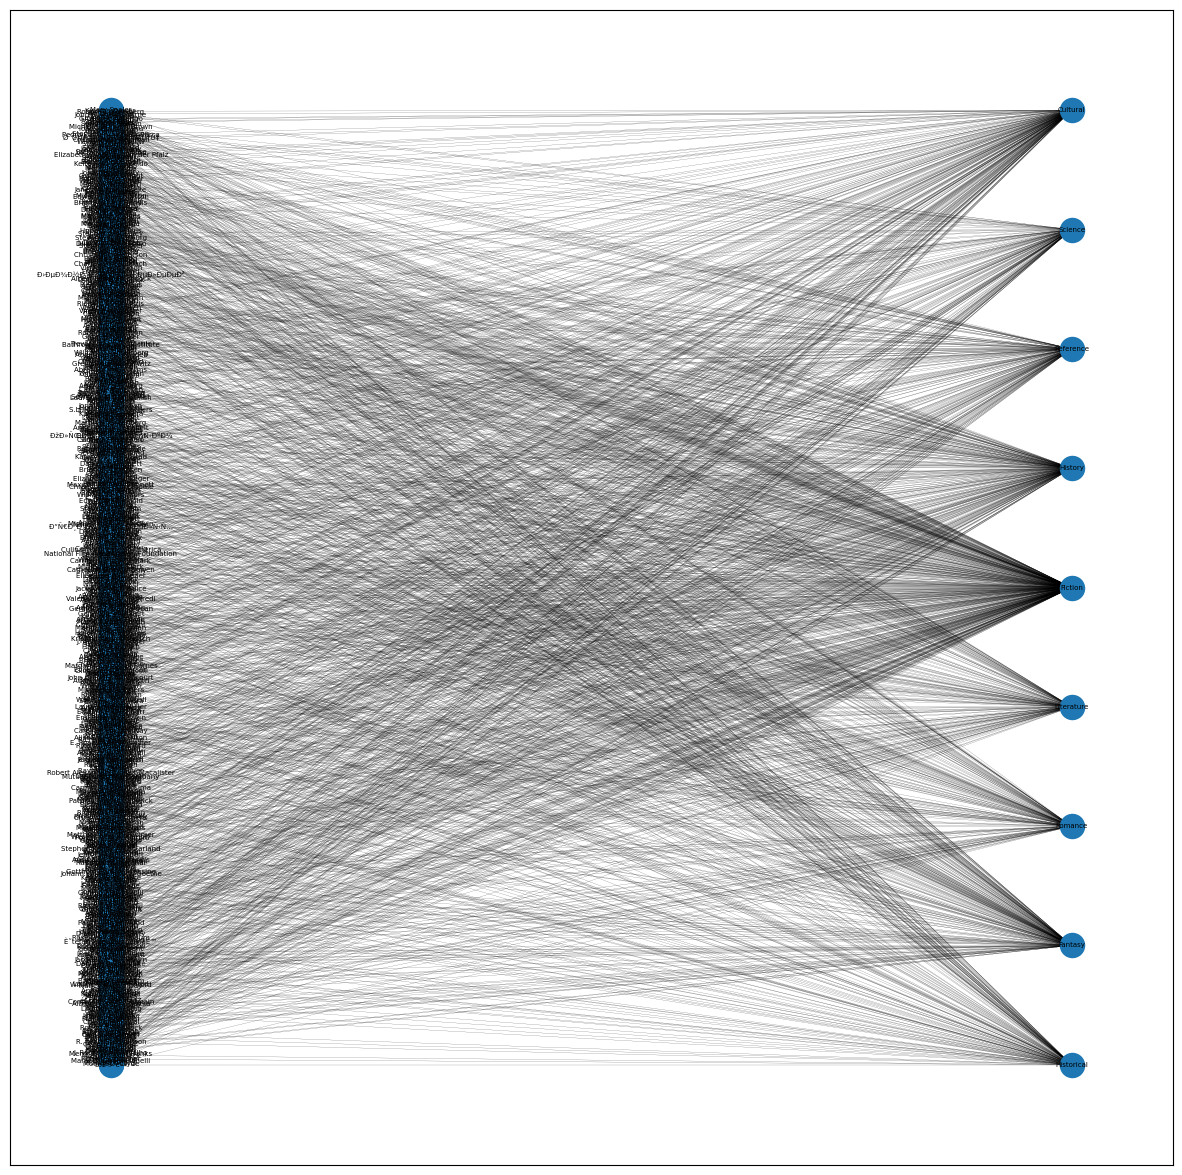

In [28]:
plt.figure(figsize=(15,15))

pos = nx.drawing.layout.bipartite_layout(B, authors)

nx.draw_networkx(B, pos=pos, with_labels=True, font_size=5, width=0.1)

plt.show()

In [29]:
G = nx.bipartite.weighted_projected_graph(B, np.unique(authors))

print(f"Số tác giả: {len(list(G.nodes()))}")
print(f"Số cạnh: {len(list(G.edges()))}")

Số tác giả: 1011
Số cạnh: 190537


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 144 (\x90) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 143 (\x8f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


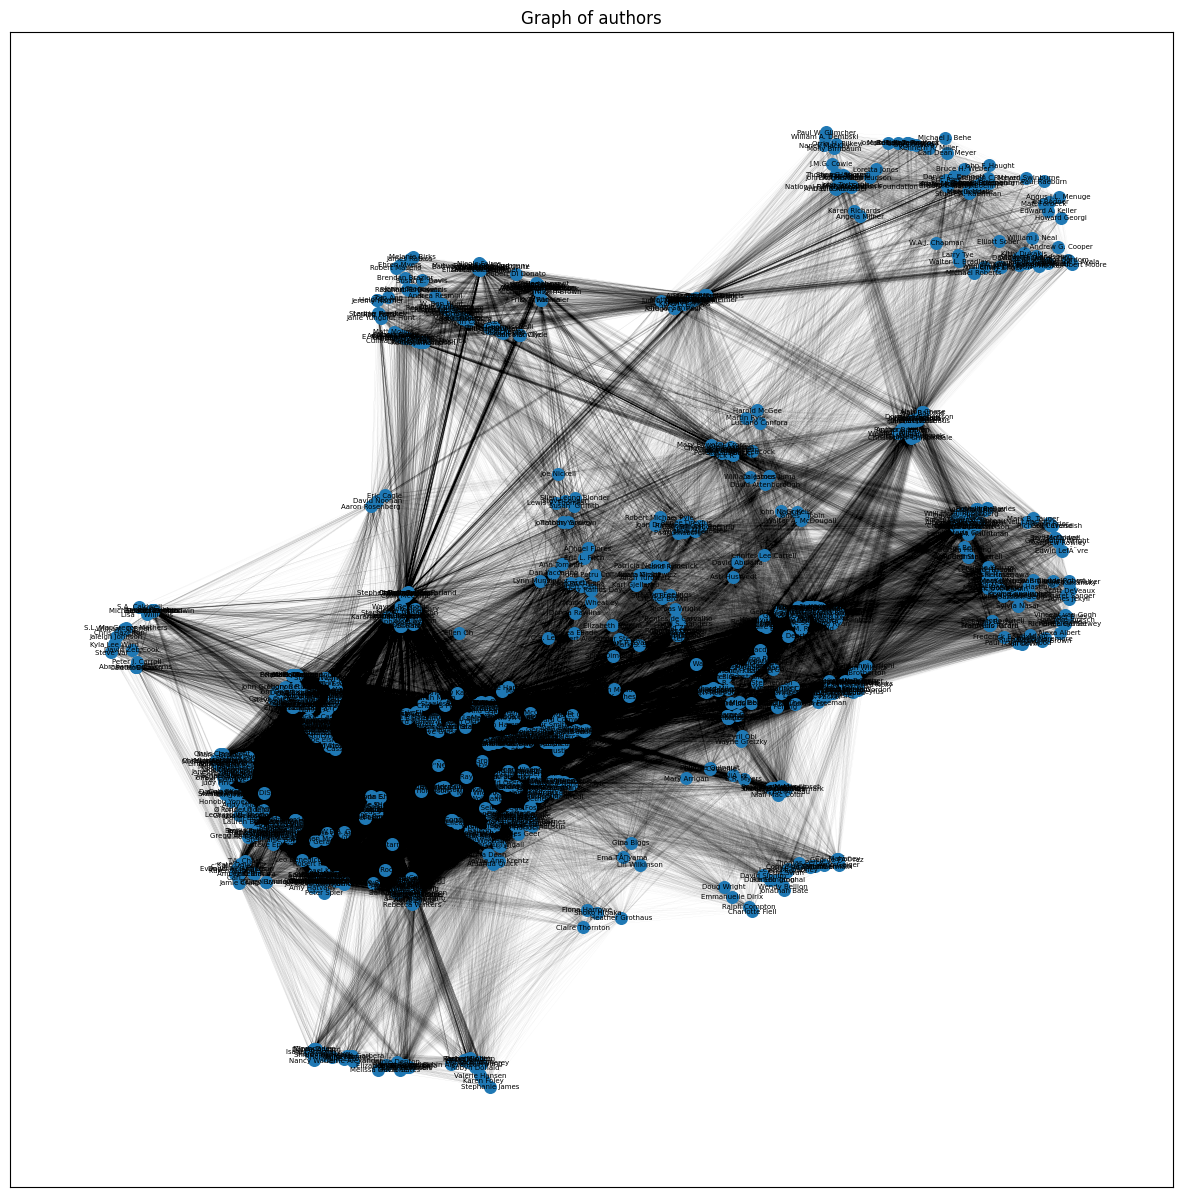

In [30]:
plt.figure(figsize = (15,15))
plt.title("Graph of authors")
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=pos, node_size=70)
nx.draw_networkx_edges(G, pos=pos, width=0.01)
nx.draw_networkx_labels(G, pos=pos, font_size=5)
plt.show()

### Degree Centrality

In [31]:
degree = nx.degree_centrality(G)

In [32]:
top_10_degree = sorted(degree.items(), key=lambda d: d[1], reverse=True)[0:10]

In [33]:
top_10_degree

[('Mircea Eliade', 0.8861386138613861),
 ('C.S. Lewis', 0.8445544554455445),
 ('Margaret George', 0.8207920792079209),
 ('Bernard Cornwell', 0.7554455445544555),
 ('Donna Rawlins', 0.7178217821782178),
 ('Nadia Wheatley', 0.7178217821782178),
 ('G.K. Chesterton', 0.7049504950495049),
 ('Amulya Malladi', 0.6831683168316832),
 ('Carol Umberger', 0.6831683168316832),
 ('EÃ§a de QueirÃ³s', 0.6831683168316832)]

Kết quả top 10 tác giả có degree centrality cao nhất

### Closeness Centrality

In [34]:
closeness = nx.closeness_centrality(G)

In [35]:
top_10_closeness = sorted(closeness.items(),\
    key=lambda c: c[1], reverse=True)[0:10]
top_10_closeness

[('Mircea Eliade', 0.8977777777777778),
 ('C.S. Lewis', 0.8654670094258783),
 ('Margaret George', 0.8480268681780017),
 ('Bernard Cornwell', 0.8035003977724742),
 ('Donna Rawlins', 0.7799227799227799),
 ('Nadia Wheatley', 0.7799227799227799),
 ('G.K. Chesterton', 0.77217125382263),
 ('Amulya Malladi', 0.7593984962406015),
 ('Carol Umberger', 0.7593984962406015),
 ('EÃ§a de QueirÃ³s', 0.7593984962406015)]

Kết quả top 10 tác giả có closeness centrality cao nhất

### Betweenness Centrality

In [36]:
betweenness_centrality = nx.betweenness_centrality(G)

In [37]:
top_10_betweenness = sorted(betweenness_centrality.items(),\
    key=lambda b: b[1], reverse=True)[0:10]
top_10_betweenness

[('Elizabeth Hallam', 0.01590156549547192),
 ('Mircea Eliade', 0.013940546484080132),
 ('C.S. Lewis', 0.012425818049890845),
 ('Margaret George', 0.012417014950342531),
 ('Bernard Cornwell', 0.011217532256318276),
 ('Donna Rawlins', 0.010065386576378286),
 ('Nadia Wheatley', 0.010065386576378286),
 ('L. King PÃ©rez', 0.009451813438686589),
 ('Nancy Raines Day', 0.009451813438686589),
 ('Robert Casilla', 0.009451813438686589)]

Kết quả top 10 tác giả có betweenness centrality cao nhất

### Page Rank

In [38]:
pagerank = nx.pagerank(G)

In [39]:
top_10_pagerank = sorted(pagerank.items(),\
    key=lambda p: p[1], reverse=True)[0:10]
top_10_pagerank

[('Mircea Eliade', 0.0030748872366492884),
 ('Margaret George', 0.002924231736012607),
 ('C.S. Lewis', 0.002689785087401737),
 ('Bernard Cornwell', 0.002265705138449381),
 ('Amulya Malladi', 0.002073198899581464),
 ('Carol Umberger', 0.002073198899581464),
 ('EÃ§a de QueirÃ³s', 0.002073198899581464),
 ('L.M. Montgomery', 0.002073198899581464),
 ('Margaret Jull Costa', 0.002073198899581464),
 ('Asti Hustvedt', 0.0019931055877241816)]

Kết quả top-10 tác giả có page rank cao nhất

### Harmonic

In [40]:
harmonic = nx.harmonic_centrality(G)

In [41]:
top_10_harmonic = sorted(harmonic.items(), key = lambda h: h[1], reverse = True)[0:10]
top_10_harmonic

[('Mircea Eliade', 952.5),
 ('C.S. Lewis', 931.5),
 ('Margaret George', 919.5),
 ('Bernard Cornwell', 886.5),
 ('Donna Rawlins', 867.5),
 ('Nadia Wheatley', 867.5),
 ('G.K. Chesterton', 861.0),
 ('Margaret Jull Costa', 850.0),
 ('Carol Umberger', 850.0),
 ('L.M. Montgomery', 850.0)]

Kết quả top 10 tác giả có độ đo harmonic cao nhất

### Eigenvector Centrality

In [42]:
eigenvector = nx.eigenvector_centrality(G)

In [43]:
top_10_eigenvector = sorted(eigenvector.items(), key=lambda e: e[1], reverse=True)[0:10]
top_10_eigenvector

[('Mircea Eliade', 0.0535367321043556),
 ('Margaret George', 0.05314914992855482),
 ('C.S. Lewis', 0.05224492658559883),
 ('Bernard Cornwell', 0.05121594494241083),
 ('Amulya Malladi', 0.050277258071561914),
 ('Carol Umberger', 0.050277258071561914),
 ('EÃ§a de QueirÃ³s', 0.050277258071561914),
 ('L.M. Montgomery', 0.050277258071561914),
 ('Margaret Jull Costa', 0.050277258071561914),
 ('Arthur Waley', 0.04960074455107768)]

Kết quả top 10 tác giả có độ đo eigenvector cao nhất

## Các thuật toán khám phá cộng đồng

### Thuật toán Louvain

In [44]:
import community as community_louvain

partition = community_louvain.best_partition(G)
values = list(partition.values())
print("Number of communities: ", len(np.unique(values)))

Number of communities:  3


##### Mô hình trực quan đồ thị theo Louvain

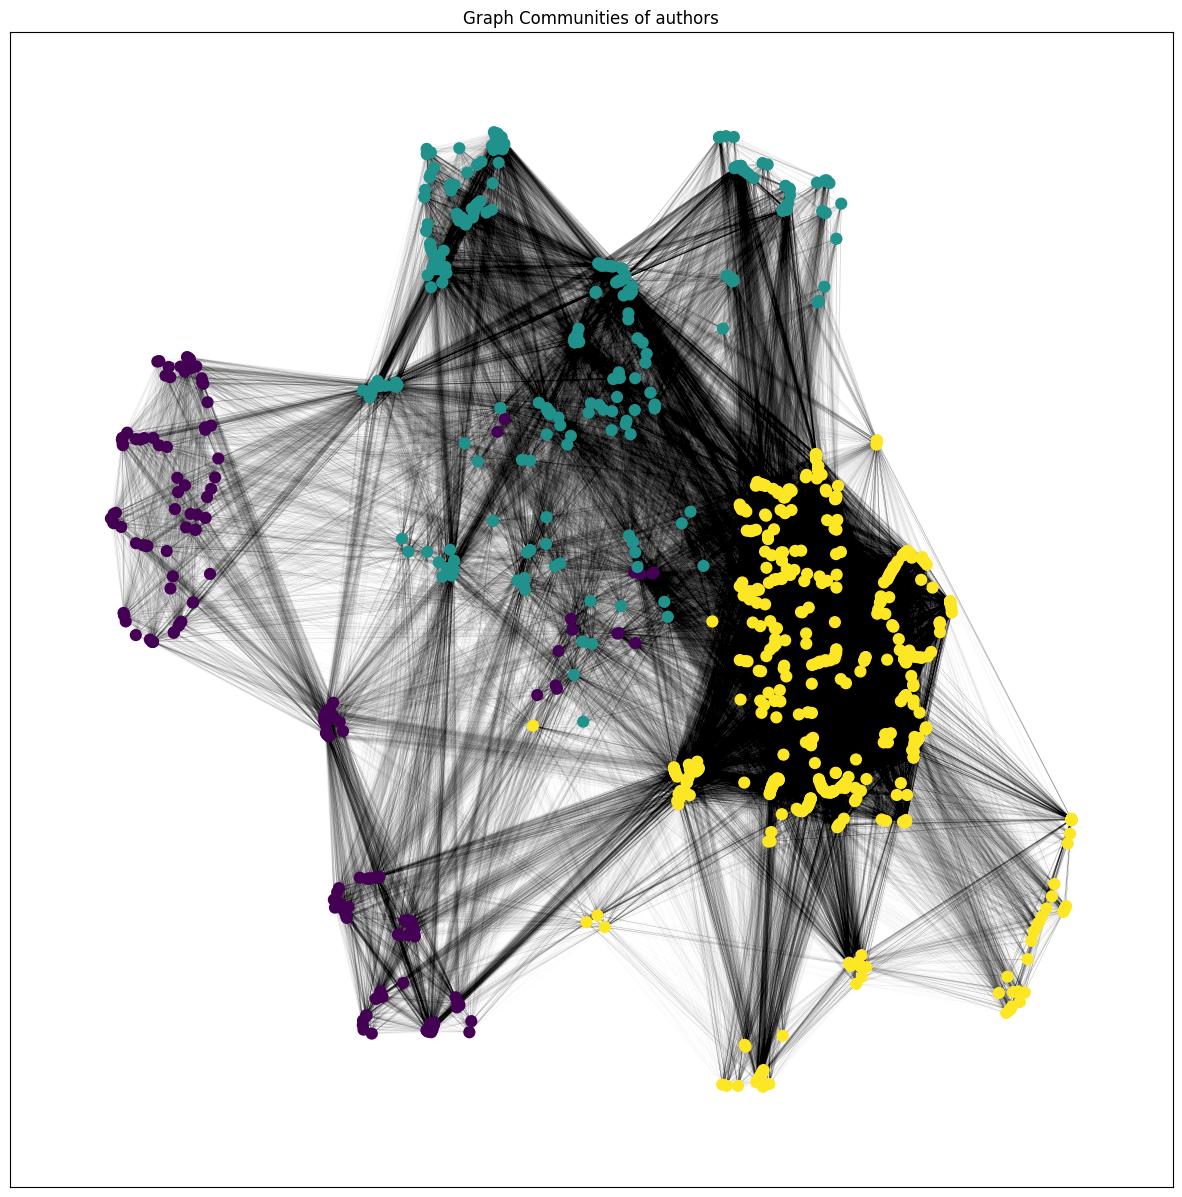

In [45]:
plt.figure(figsize = (15,15))

plt.title("Graph Communities of authors")

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos=pos, node_size=60, node_color=values)
nx.draw_networkx_edges(G, pos=pos, width=0.01)

plt.show()

### Lấy danh sách các tác giả trong từng cộng đồng

In [46]:
# Tạo từ điển để lưu danh sách tác giả của từng cộng đồng
community_authors = {}

for node, community in partition.items():
    # Lấy tên tác giả từ nút
    author = node
    
    if community not in community_authors:
        community_authors[community] = []
    
    # Thêm tên tác giả vào danh sách của cộng đồng tương ứng
    if author:
        community_authors[community].append(author)

### Vẽ biểu đồ cột thể hiện các thể loại có trong mô hình

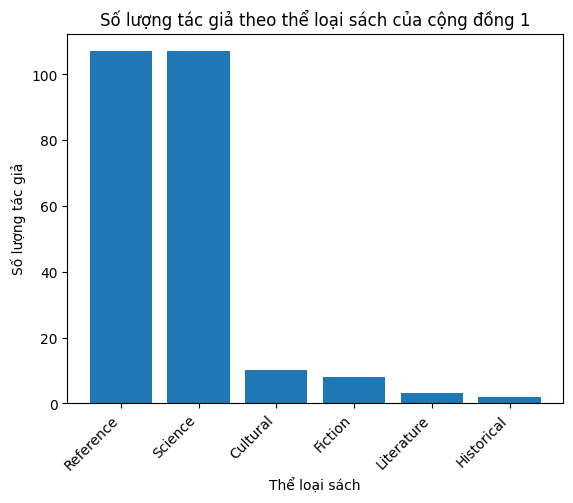

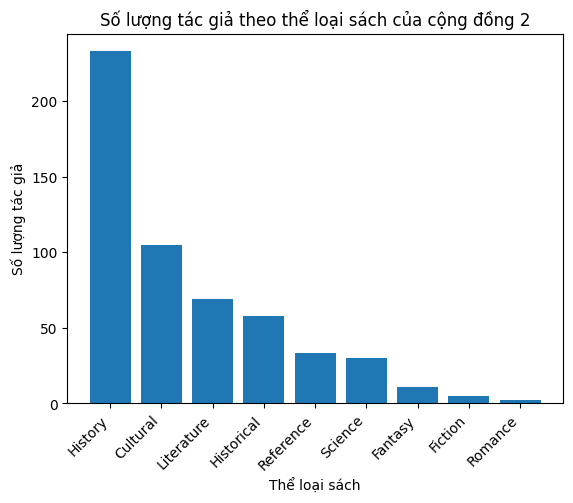

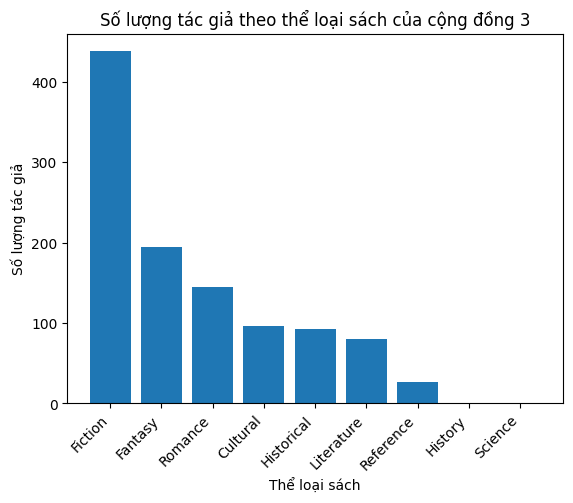

In [47]:
for community in sorted(community_authors.keys()):
    authors = community_authors[community]
    # Lọc các tác giả thuộc cộng đồng
    filtered_df = pair_df[pair_df['author'].isin(authors)]
    
    # Groupby theo thể loại và đếm số lượng tác giả
    result_df = filtered_df.groupby('genre').agg({'author': 'nunique'}).reset_index()
    
    # Đổi tên cột
    result_df.columns = ['genre', 'author_count']
    
    # Sắp xếp theo author_count
    result_df = result_df.sort_values(by='author_count', ascending=False)
    
    # Vẽ biểu đồ cột
    plt.bar(result_df['genre'], result_df['author_count'])
    plt.xlabel('Thể loại sách')
    plt.ylabel('Số lượng tác giả')
    plt.title(f'Số lượng tác giả theo thể loại sách của cộng đồng {community + 1}')
    plt.xticks(rotation=45, ha='right')  # Để tránh trùng lắp tên thể loại
    plt.show()

#### Nhận xét về từng cộng đồng

Viết cái gì đó nhận xét cộng đồng ở đây

### K-means

##### Mô hình trực quan về các cộng đồng bằng K-means

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

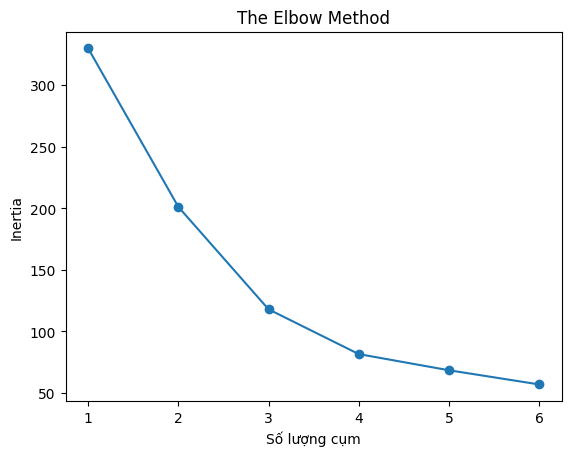

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

le = LabelEncoder()
X = pair_df

# Chuyển các biến phân loại thành biến số
X = X.apply(lambda col: le.fit_transform(col))

# Tính toán MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Sử dụng dữ liệu đã được scaled để thực hiện KMeans
n_clusters = range(1, 7)
s_dis = [KMeans(n_clusters=i).fit(X_scaled).inertia_ for i in n_clusters]

# Vẽ biểu đồ Elbow Method
plt.plot(n_clusters, s_dis, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Số lượng cụm')
plt.ylabel('Inertia')
plt.show()

#### Thuật toán tìm số cụm tối ưu

In [49]:
def find_optimal_clusters_elbow(s_dis):
    deltas = np.diff(s_dis, 2)
    elbow_index = np.argmin(deltas) + 2  # Cộng thêm 2 vì np.diff giảm kích thước mảng đi 2
    return elbow_index

optimal_clusters = find_optimal_clusters_elbow(s_dis)
print(f"Số lượng cụm tối ưu là: {optimal_clusters}")

Số lượng cụm tối ưu là: 5


#### Vẽ biểu đồ của từng cộng đồng

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


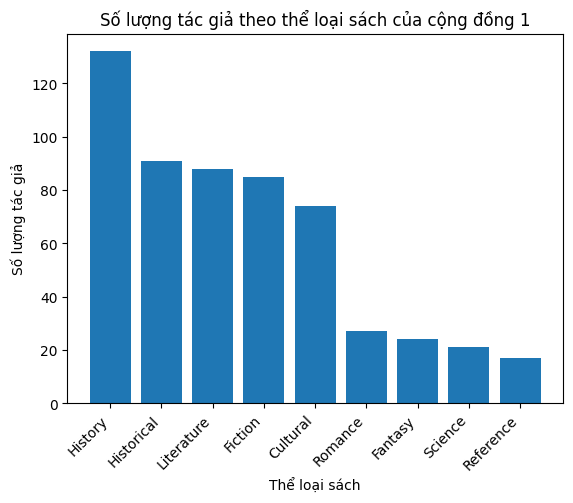

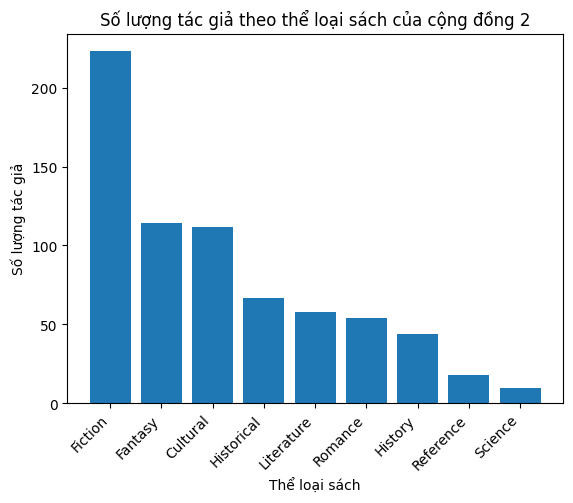

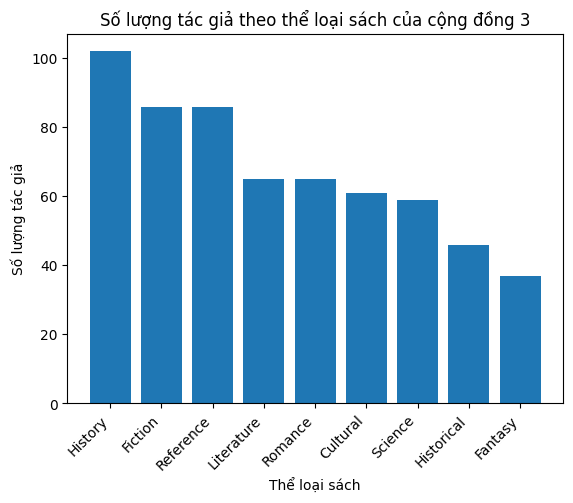

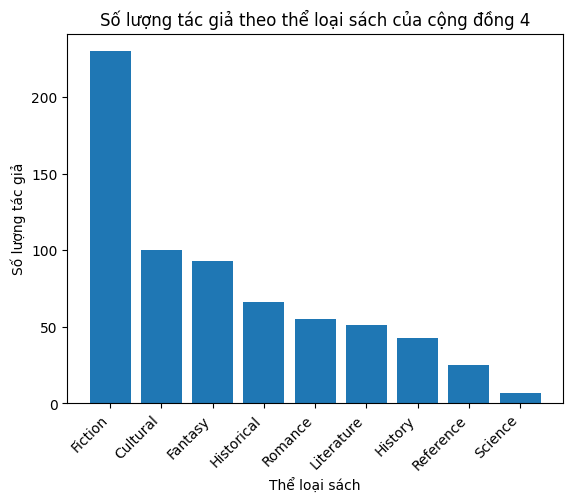

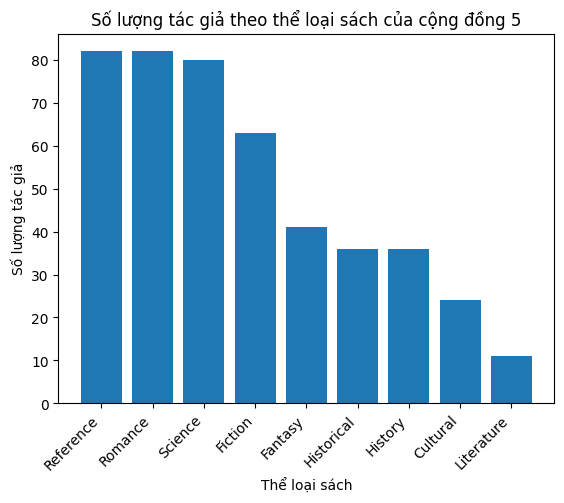

In [50]:
kmeans = KMeans(n_clusters=optimal_clusters)
kmeans.fit(X_scaled)
labels = kmeans.labels_

df2 = pair_df.copy()
df2['cluster_label'] = labels

authors_by_cluster = df2.groupby('cluster_label')['author'].unique()

for cluster, authors in authors_by_cluster.items():
    # Lọc dữ liệu cho cụm đó
    cluster_data = df2[df2['author'].isin(authors)]
    
    # Groupby theo thể loại và đếm số lượng tác giả
    result_df = cluster_data.groupby('genre').agg({'author': 'nunique'}).reset_index()
    
    # Đổi tên cột
    result_df.columns = ['genre', 'author_count']
    
    # Sắp xếp theo author_count
    result_df = result_df.sort_values(by='author_count', ascending=False)
    
    # Vẽ biểu đồ cột
    plt.bar(result_df['genre'], result_df['author_count'])
    plt.xlabel('Thể loại sách')
    plt.ylabel('Số lượng tác giả')
    plt.title(f'Số lượng tác giả theo thể loại sách của cộng đồng {cluster + 1}')
    plt.xticks(rotation=45, ha='right')  # Để tránh trùng lắp tên thể loại
    plt.show()

### Thuật toán Spectral Clustering

#### Mô hình trực quan

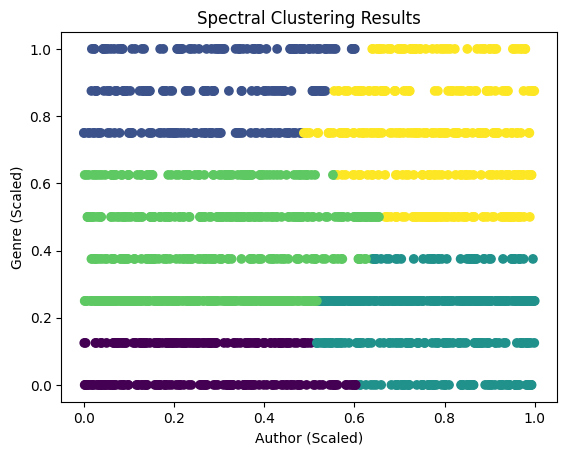

In [51]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=optimal_clusters, assign_labels="discretize", random_state=0)

spectral.fit(X_scaled)

cluster_labels = spectral.labels_
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Spectral Clustering Results')
plt.xlabel('Author (Scaled)')
plt.ylabel('Genre (Scaled)')
plt.show()

#### Vẽ biểu đồ của từng cộng đồng

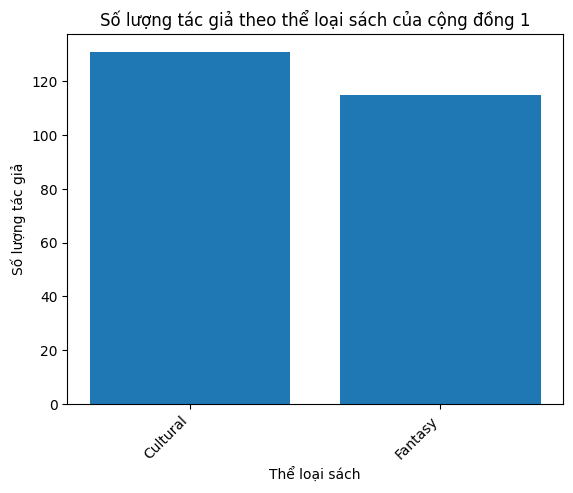

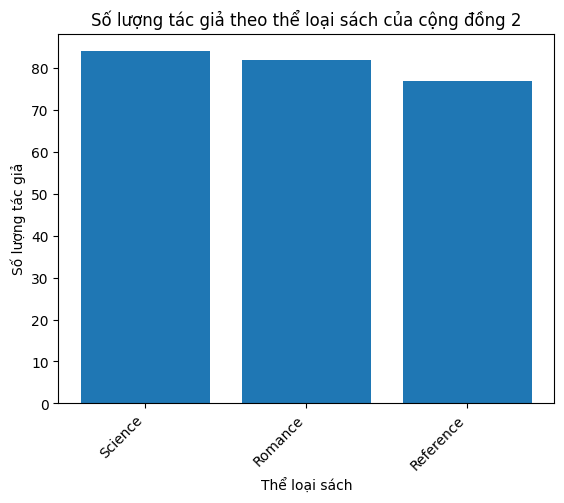

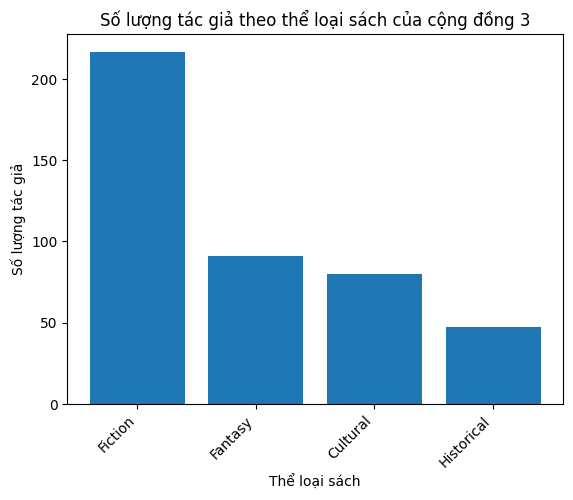

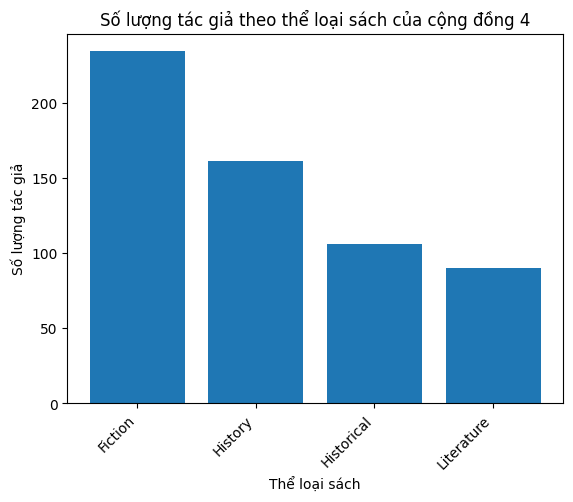

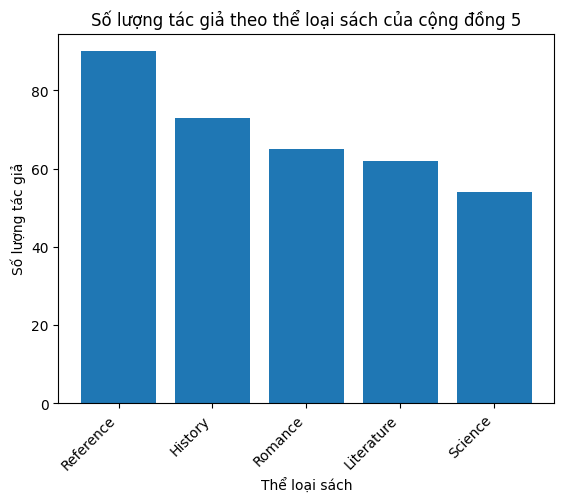

In [52]:
df2 = pair_df.copy()
df2['spectral_cluster_label'] = spectral.labels_

# Vẽ biểu đồ cột cho từng cộng đồng
for cluster_label in sorted(df2['spectral_cluster_label'].unique()):
    # Lọc dữ liệu cho cụm đó
    cluster_data = df2[df2['spectral_cluster_label'] == cluster_label].copy()
    
    # Groupby theo thể loại và đếm số lượng tác giả
    result_df = cluster_data.groupby('genre').agg({'author': 'nunique'}).reset_index()
    
    # Đổi tên cột
    result_df.columns = ['genre', 'author_count']
    
    # Sắp xếp theo author_count
    result_df = result_df.sort_values(by='author_count', ascending=False)
    
    # Vẽ biểu đồ cột    
    plt.bar(result_df['genre'], result_df['author_count'])
    plt.xlabel('Thể loại sách')
    plt.ylabel('Số lượng tác giả')
    plt.title(f'Số lượng tác giả theo thể loại sách của cộng đồng {cluster_label + 1}')
    plt.xticks(rotation=45, ha='right')  # Để tránh trùng lắp tên thể loại
    plt.show()